In [1]:
!ls

holidays_events.csv  __MACOSX  recmetrics      sample_data  train_8M.csv
items.csv	     oil.csv   recmetrics.zip  stores.csv   transactions.csv


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import tensorflow as tf
import random
sns.set()

In [0]:
items = pd.read_csv("items.csv")
holiday_events = pd.read_csv("holidays_events.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
transactions = pd.read_csv("transactions.csv",parse_dates=['date'])
train = pd.read_csv("train_8M.csv", nrows = 500000, parse_dates=['date'])

In [0]:
stores = train['store_nbr'].values
items = train['item_nbr'].values
reward = train['unit_sales'].values

In [5]:
encoded = LabelEncoder().fit_transform(items)
items_unique = np.unique(items)
items_unique

array([  96995,  103501,  103520, ..., 1114567, 1114749, 1118683])

In [0]:
from sklearn.model_selection import train_test_split

train_stores, test_stores, train_items, test_items, train_reward, test_reward, train, test = train_test_split(stores, encoded, reward,
                                                                                                              train, test_size = 0.25,
                                                                                                             shuffle = False)

In [8]:
SEQ_LEN = 5

# group every 5 days
slide_train_stores = [train_stores[i: i + SEQ_LEN] for i in range(len(train_stores) - SEQ_LEN)]
slide_train_stores[:3]

[array([25, 25, 25, 25, 25]),
 array([25, 25, 25, 25, 25]),
 array([25, 25, 25, 25, 25])]

In [9]:
from collections import deque
import random

tf.reset_default_graph()

LEARNING_RATE = 1e-5
LAYER_SIZE = 256
OUTPUT_SIZE = np.unique(items).shape[0]
STATE_SIZE = np.unique(stores).shape[0]
SEQ_LEN = 5

class Model:
  def __init__(self):
    self.X = tf.placeholder(tf.int32, [None, None])
    self.Y = tf.placeholder(tf.float32, [None, OUTPUT_SIZE])
    self.memory = deque(maxlen = 1000)
    
    self.gamma = 0.95
    self.epsilon = 0.5
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.999
        
    embeddings = tf.Variable(tf.random_uniform([STATE_SIZE, LAYER_SIZE], -1, 1))
    embedded = tf.nn.embedding_lookup(embeddings, self.X) # batch size, time, dimension
    cell = tf.nn.rnn_cell.LSTMCell(LAYER_SIZE, state_is_tuple = False)
    self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * LAYER_SIZE))
    output, self.last_state = tf.nn.dynamic_rnn(inputs=embedded,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
    self.logits = tf.layers.dense(output[:,-1], OUTPUT_SIZE)
    self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
    self.optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(
        self.cost
    )
    self.sess = tf.InteractiveSession()
    self.sess.run(tf.global_variables_initializer())
  
  def act(self, state, memory):
    if random.random() <= self.epsilon:
      return np.random.randint(OUTPUT_SIZE, size = (len(state))), memory
    a, new_memory = self.sess.run([self.logits, self.last_state], 
                                  feed_dict = {self.X: state, self.hidden_layer: memory})
    return np.argmax(a, axis = 1), new_memory
      
  def replay(self, batch_size):
    mini_batch = random.sample(self.memory, batch_size)
    replay_size = len(mini_batch)
    X = []
    Y = np.empty((replay_size, OUTPUT_SIZE))
    MEMORIES = np.empty((replay_size, 2 * LAYER_SIZE))
    states = np.array([a[0] for a in mini_batch])
    new_states = np.array([a[3] for a in mini_batch])
    memories = np.array([a[-1] for a in mini_batch])
    Q = self.sess.run(self.logits, feed_dict = {self.X: states, self.hidden_layer: memories})
    Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states, self.hidden_layer: memories})
    for i in range(len(mini_batch)):
        state, action, reward, next_state, done, rnn_memory = mini_batch[i]
        target = Q[i]
        target[action] = reward
        if not done:
            target[action] += self.gamma * np.amax(Q_new[i])
        X.append(state)
        Y[i] = target
        MEMORIES[i] = rnn_memory
    cost, _ = self.sess.run(
        [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y, self.hidden_layer: MEMORIES}
    )
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay
    return cost
  
model = Model()

W0726 09:01:06.959889 140467048884096 deprecation.py:323] From <ipython-input-9-607ce0ffea9d>:25: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0726 09:01:06.962265 140467048884096 rnn_cell_impl.py:893] <tensorflow.python.ops.rnn_cell_impl.LSTMCell object at 0x7fc0b0e7c748>: Using a concatenated state is slower and will soon be deprecated.  Use state_is_tuple=True.
W0726 09:01:06.967222 140467048884096 deprecation.py:323] From <ipython-input-9-607ce0ffea9d>:29: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0726 09:01:07.025481 140467048884096 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:12

In [10]:
init_value = np.zeros((10, 2 * LAYER_SIZE))
model.sess.run(model.logits, feed_dict = {model.X: slide_train_stores[:10], 
                                          model.hidden_layer: init_value})

array([[ 0.11518549,  0.08146434,  0.03062934, ..., -0.03425309,
        -0.0112058 ,  0.11249982],
       [ 0.11518549,  0.08146434,  0.03062934, ..., -0.03425309,
        -0.0112058 ,  0.11249982],
       [ 0.11518549,  0.08146434,  0.03062934, ..., -0.03425309,
        -0.0112058 ,  0.11249982],
       ...,
       [ 0.11518549,  0.08146434,  0.03062934, ..., -0.03425309,
        -0.0112058 ,  0.11249982],
       [ 0.11518549,  0.08146434,  0.03062934, ..., -0.03425309,
        -0.0112058 ,  0.11249982],
       [ 0.11518549,  0.08146434,  0.03062934, ..., -0.03425309,
        -0.0112058 ,  0.11249982]], dtype=float32)

In [0]:
train_pivoted = train.pivot_table(index='store_nbr', columns='item_nbr', values='unit_sales').fillna(0)

In [12]:
from tqdm import tqdm
epoch = 5
batch_size = 128

for e in range(epoch):
  pbar = tqdm(
      range(0, len(slide_train_stores) - 1, batch_size), desc = 'train minibatch loop'
    )
  loss = []
  for i in pbar:
    index = min(i + batch_size, len(slide_train_stores) - 1)
    state = slide_train_stores[i: index]
    init_value = np.zeros((len(state), 2 * LAYER_SIZE))
    action, init_value = model.act(state, init_value)
    next_state = slide_train_stores[i + 1: index + 1]
    for no, a in enumerate(action):
      if a >= train_pivoted.shape[1]:
        r = 0
      else:
        r = train_pivoted.loc[slide_train_stores[i + no][-1]].iloc[a]
      model.memory.append((state[no], a, r, next_state[no], r  < 1, init_value[-1]))
    cost = model.replay(min(batch_size, len(model.memory)))
    pbar.set_postfix(cost = cost)
    loss.append(cost)
  print('\nepoch: %d, average lost: %f'%(e + 1, np.mean(loss)))

train minibatch loop:   0%|          | 3/2930 [00:00<01:55, 25.38it/s, cost=3.04e+3]


epoch: 1, average lost: 937652.250000


train minibatch loop:   0%|          | 3/2930 [00:00<01:59, 24.55it/s, cost=294]


epoch: 2, average lost: 106628.664062


train minibatch loop:   0%|          | 3/2930 [00:00<01:57, 24.90it/s, cost=2.35e+5]


epoch: 3, average lost: 187005.640625


train minibatch loop:   0%|          | 3/2930 [00:00<01:57, 24.89it/s, cost=603]   


epoch: 4, average lost: 237183.234375


train minibatch loop: 100%|██████████| 2930/2930 [02:01<00:00, 24.20it/s, cost=1.08e+3]


epoch: 5, average lost: 173671.093750


In [13]:
test_cp = test.copy().groupby('store_nbr')['item_nbr'].agg({'actual': (lambda x: list(set(x)))})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [0]:
def get_users_predictions(user_id, n):
  init_value = np.zeros((1, 2 * LAYER_SIZE))
  p = model.sess.run(model.logits, feed_dict = {model.X: [[user_id]], model.hidden_layer: init_value})[0]
  p = p.argsort()[-n:][::-1]
  return [items_unique[i] for i in p]

In [0]:
recs = []
for user in test_cp.index:
    cf_predictions = get_users_predictions(user + 1, 30)
    recs.append(cf_predictions)

In [16]:
test_cp['cf_predictions'] = recs
test_cp.head()

,actual,cf_predictions
store_nbr,,
1,"[174081, 1058820, 862213, 819206, 460804, 8192...","[265559, 115894, 114778, 687549, 462673, 12360..."
2,"[174081, 460804, 862213, 819206, 1058820, 8192...","[265559, 115894, 987308, 114778, 414353, 12360..."
3,"[174081, 460804, 862213, 819206, 1058820, 8192...","[265559, 987308, 115894, 114778, 687549, 11526..."
4,"[174081, 460804, 862213, 819206, 1058820, 8192...","[265559, 115894, 114778, 687549, 123601, 11526..."
5,"[174081, 460804, 862213, 819206, 1058820, 8192...","[265559, 115894, 114778, 123601, 687549, 10477..."


In [0]:
popularity_recs = train.item_nbr.value_counts().head(30).index.tolist()

recs = []
for user in test_cp.index:
    pop_predictions = popularity_recs
    recs.append(pop_predictions)

In [0]:
test_cp['pop_predictions'] = recs
test_cp.head()

recs = []
for user in test_cp.index:
    random_predictions = train.item_nbr.sample(30).values.tolist()
    recs.append(random_predictions)

In [0]:
test_cp['random_predictions'] = recs
test_cp.head()

actual = test_cp.actual.values.tolist()
cf_predictions = test_cp.cf_predictions.values.tolist()
pop_predictions = test_cp.pop_predictions.values.tolist()
random_predictions = test_cp.random_predictions.values.tolist()

In [20]:
import recmetrics

pop_mark = []
for K in np.arange(1, 31):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.000984488736644838,
 0.001968977473289676,
 0.0029534662099345134,
 0.003937954946579352,
 0.004922443683224189,
 0.005906932419869027,
 0.006891421156513865,
 0.007875909893158704,
 0.008860398629803541,
 0.009844887366448379,
 0.010829376103093216,
 0.011813864839738054,
 0.012772130258608726,
 0.01375474590112684,
 0.014737486416586733,
 0.01572033619587069,
 0.01670328238441116,
 0.01768631427006855,
 0.018669422832093687,
 0.01965260040284982,
 0.02063584041007684,
 0.02161913717773194,
 0.02260248577012573,
 0.02358588186852998,
 0.024569321672463843,
 0.02555280181996352,
 0.02653631932261673,
 0.027519871512198205,
 0.028503455996506003,
 0.02946992619792526]

In [21]:
random_mark = []
for K in np.arange(1, 31):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.0006955911830410456,
 0.0013872729522819251,
 0.0020828665002244435,
 0.0026990838841800114,
 0.003389916485172785,
 0.00394537119391537,
 0.004512275352232302,
 0.00506735377372124,
 0.005638287943909905,
 0.0062752247611812416,
 0.006901843243527864,
 0.007565210075034994,
 0.008147204421887728,
 0.008705252410469539,
 0.009339213420016661,
 0.009932571816340557,
 0.010490910351069969,
 0.011144860005868697,
 0.011723398114836173,
 0.01221269392106548,
 0.012820588532383912,
 0.013343436649997672,
 0.013886889596796298,
 0.014410122473900635,
 0.014949888881893168,
 0.015476462297457201,
 0.01603848566916652,
 0.01651633246510759,
 0.01713579096324047,
 0.017666674452261836]

In [22]:
cf_mark = []
for K in np.arange(1, 31):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.0007373119983490397,
 0.00141103230625563,
 0.001992903101585501,
 0.002608368772650804,
 0.0033385587407702448,
 0.0040506946052840526,
 0.004778673860720364,
 0.005514648138512755,
 0.006263025578879958,
 0.007030358064078298,
 0.007747269500955702,
 0.00849061262079452,
 0.009254550700539,
 0.010041517412920871,
 0.010800574129385197,
 0.011523920033706706,
 0.012263386686919344,
 0.012981045691058148,
 0.013694316842527582,
 0.014396975278523147,
 0.015170740250816632,
 0.015911202930677187,
 0.016627734811346807,
 0.017332801838466968,
 0.018124486475227762,
 0.01880935592787233,
 0.019412098106912707,
 0.02003318510545649,
 0.02079751213570718,
 0.021409453437785744]

In [0]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,30+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter qlearning']

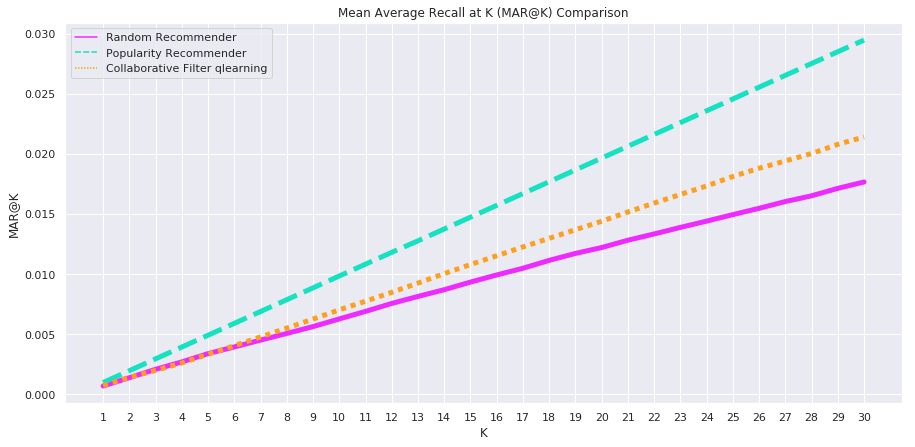

In [24]:
fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

In [0]:
catalog = train.item_nbr.unique().tolist()
random_coverage = recmetrics.coverage(random_predictions, catalog)
pop_coverage = recmetrics.coverage(pop_predictions, catalog)
cf_coverage = recmetrics.coverage(cf_predictions, catalog)

In [0]:
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter deep-Q']

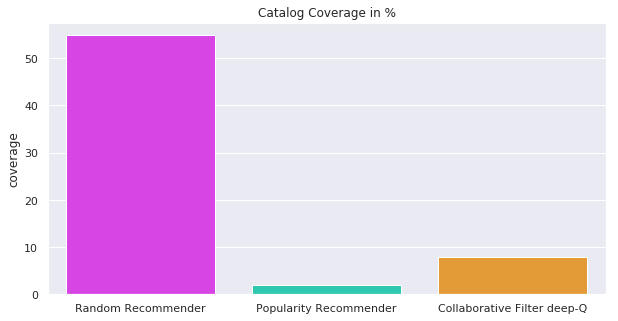

In [27]:
fig = plt.figure(figsize=(10, 5))
recmetrics.coverage_plot(coverage_scores, model_names)